## Application of EMIT: Agricultural Lands
### South Platte and Republican River Basins, CO, USA

The South Platte basin is the most populus river basin in Colorado with more than 70% of the state's population living within this region (**[Colorado Water Plan Version 2; South Platte/Metro](https://dnrweblink.state.co.us/cwcbsearch/0/edoc/216720/South_Platte-Metro_BIP_Volume2_2022.pdf)**). This region also has the greatest concentration of irrigated lands in the state.

Add more introduction here.

~add more info and a map/image~

![Water Figure 14](https://raw.githubusercontent.com/CU-ESIIL/HYR-SENSE/main/images/water_fig14.png)
Image source: https://cwcb.colorado.gov/colorado-water-plan/technical-update-to-the-plan

## Search and Download EMIT Data Products

In this notebook, we will use the 'earthaccess' Python package to search and download EMIT scenes which overlap agricultural lands in the South Platte river basin (refer to this notebook for the introduction to earthaccess: XXX). Using this package, we can search for EMIT scenes using a region of interest and identify data granules which meet certain criteria for analysis (i.e., cloud cover, seasonality, etc). 

### Step 1. Setup notebook

First, we need to import packages and set up some environment variables for the notebook.

In [2]:
# Import modules and env vars

import os, time, shutil
import folium
import earthaccess
import warnings
import folium.plugins
import pandas as pd
import geopandas as gpd
import rioxarray as rxr
import rasterio as rio
import numpy as np
import math

from rasterio.plot import show
from branca.element import Figure
from IPython.display import display
from shapely import geometry
from skimage import io
from datetime import timedelta
from shapely.geometry.polygon import orient
from matplotlib import pyplot as plt

dest = '/home/jovyan/HYR-SENSE/data/Agriculture'

# Define some projections
albers = 'EPSG:5070' # Albers Equal Area CONUS

print("Success!")

Success!


#### Transfer project data from the cloud

We want to copy over data stored in CyVerse so that we can access files quickly for analysis. To do this, we will use Python "shutil" package to copy files from the CyVerse data store to a local, temporary location in the HYR-SENSE GitHub repository. The data we are copying is stored in a shared ESIIL / HYR-SENSE location. We can copy the files just from the "Agriculture" module which contains data for this exercise. However, if you want to work with other modules, they can be accessed here as well.

In [ ]:
"""
Copy the data-store to 'local' directory
This enables quick access to data files
"""

# Identify the location of the HYR-SENSE "data store"
data_store_path = '/data-store/iplant/home/shared/esiil/HYR_SENSE/data/Agriculture'
# Set a destination path (this is a 'local' and temporary path)
dest = '/home/jovyan/HYR-SENSE/data/Agriculture/' # in the GitHub repo we cloned
if not os.path.exists(dest):
    os.mkdir(dest) # create the directory for the copied data, if needed
    
# Using 'shutil' package, copy all the files over
shutil.copytree(data_store_path, dest, dirs_exist_ok=True)

### Step 2. Load Data

#### Region of Interest: South Platte River Basin

Let's start by loading the boundary data for the South Platte river basin. This data comes from the Watershed Boundary Dataset (WBD) Hydrologic Unit Codes (HUC). Specifically, we are loading the HUC6 South Platte boundary.

EPSG:5070


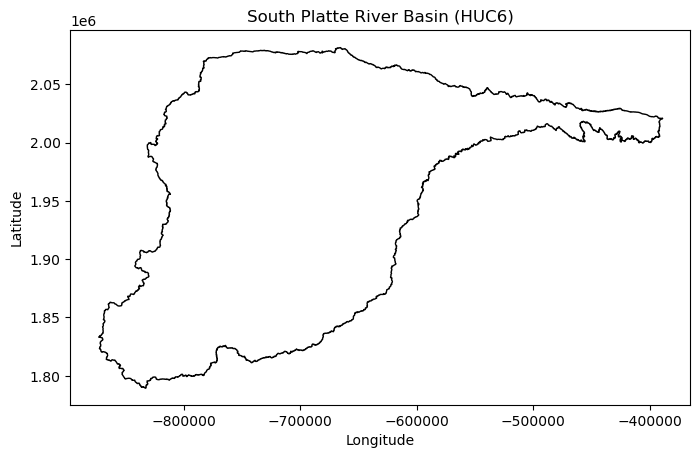

In [4]:
# Region of interest
roi = os.path.join(dest,'WBD_HUC6_South_Platte.gpkg')
roi = gpd.read_file(roi).to_crs(albers)
print(roi.crs)

# Plot the ROI data
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
roi.plot(ax=ax, color='white', edgecolor='black')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('South Platte River Basin (HUC6)')
plt.show()

### Agricultural land use data

In order to get a better picture of where the agricultural land is within the basin, we will load two datasets from the National Agricultural Statistics Service (NASS); 1 - the Cropland Data Layer (CDL) cultivated lands mask, and 2 - the CDL crop type data. To learn more about these data, visit https://croplandcros.scinet.usda.gov.

In [5]:
# NASS CDL (ca. 2023)
cdl = os.path.join(dest,'CDL_Cultivated_2023_SouthPlatte.tif')
cdl = rxr.open_rasterio(cdl, mask=True, cache=False).squeeze().astype(rio.uint8)
cdl = cdl.where(cdl != 0, np.nan)
print(cdl)
print(cdl.rio.crs) # Check to make sure the projection matches (EPSG:5070)
cdl = cdl.rio.clip(roi.geometry) # clip to the roi for consistency

<xarray.DataArray (y: 9742, x: 16122)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    band         int64 1
  * x            (x) float64 -8.731e+05 -8.731e+05 ... -3.895e+05 -3.895e+05
  * y            (y) float64 2.082e+06 2.082e+06 2.082e+06 ... 1.79e+06 1.79e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  2 (pixels/inch)
    TIFFTAG_SOFTWARE:        E
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    LAYER_TYPE:              thematic
    scale_factor:            1.0
    add_offset:              0.0
    long_name:               Layer_1
EPSG:5070


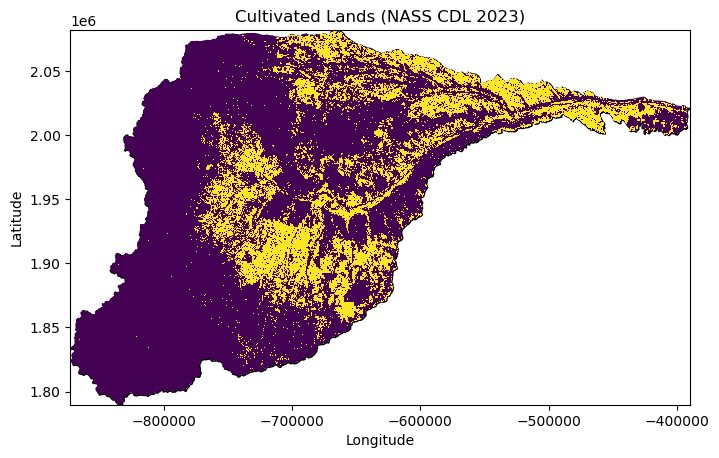

In [6]:
# Plot the ROI data
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
roi.plot(ax=ax, color='white', edgecolor='black')
cdl.plot(ax=ax, add_colorbar=False, cmap='viridis')  # Customize the colormap as neededplt.title('ROI for Agriculture Lands in South Platte Basin')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Cultivated Lands (NASS CDL 2023)')
plt.show()

## Search for EMIT Data

Using the 'earthaccess' Python package, we can search for EMIT data which overlaps our region of interest. In order to identify data which we can use for analysis, we will also filter for things like season and cloud cover using the metadata for EMIT granules. 

In [7]:
import earthaccess 

# Log in to your NASA Earthdata
# You only have to do this once in your session (persist=True saves the credentials)
earthaccess.login(persist=True)

Now we can use the search functionality of 'earthaccess' to identify data products related to the EMIT mission. This code chunk will return "short names" of the data products available. To get a better idea of what each of these products are, you can do a quick search using these short names. For example, to read more about the L2A Estimated Surface Reflectance and Uncertainty and Masks 60-m product you can visit: https://lpdaac.usgs.gov/products/emitl2arflv001/ which pops up when searching the short name "EMITL2ARFL".

In [9]:
# Query the collections
Query = earthaccess.collection_query().keyword('emit').provider('LPCLOUD')
print(f'Collections found: {Query.hits()}')
# Return EMIT specific products
collections = Query.fields(['ShortName']).get(Query.hits())
# Retrieve Collection Short-names
[product['short-name'] for product in [collection.summary() for collection in collections]]

Collections found: 7


['EMITL2ARFL',
 'EMITL2BCH4ENH',
 'EMITL2BCH4PLM',
 'EMITL2BMIN',
 'EMITL1BATT',
 'EMITL1BRAD',
 'EMITL3ASA']



To use a region of interest (ROI) polygon to search for EMIT data, we need to extract the coordinate pairs from our ROI (South Platte) which are then used in the search criteria. The code below will work for a single polygon or for multiple polygons if you wanted to search for data across a variety of ROIs. In this example, we use just one ROI, the South Platte River Basin.

In [10]:
# ~ Extract a list coordinate pairs for ROI ~

# First, reproject to WGS84 for coordinates are in lat/long
roi = roi.to_crs(epsg=4326)

# Extract the bounds
coord_list = []
for iter, row in roi.iterrows():    
    bounds = row['geometry'].bounds
    coord_list.append(bounds)
print(coord_list)

[(-106.21024492266417, 38.75297943672265, -100.67702707083612, 41.48929781268359)]


Now we can run a search for EMIT L2A Reflectance data (short name = 'EMITL2ARFL'). To start, we will search for EMIT data during the 2023 growing season (May-Sept). The results from our search is a list of granules which meet the criteria. These granules have associated metadata and we can convert the search results to a data frame to access the granule attributes.

In [11]:
# Search for EMIT data
search_results = earthaccess.search_data(
    short_name='EMITL2ARFL',
    bounding_box=coord_list[0], # we use [0] here because we only have one coordinate pair
    temporal=('2023-05-01','2023-09-28'),
    count=150
)
# Extract the metadata json as data frame
search_df = pd.json_normalize(search_results)
search_df.head()

Granules found: 125


,size,meta.concept-type,meta.concept-id,meta.revision-id,meta.native-id,meta.collection-concept-id,meta.provider-id,meta.format,meta.revision-date,umm.TemporalExtent.RangeDateTime.BeginningDateTime,...,umm.PGEVersionClass.PGEVersion,umm.RelatedUrls,umm.CloudCover,umm.DataGranule.DayNightFlag,umm.DataGranule.ArchiveAndDistributionInformation,umm.DataGranule.ProductionDateTime,umm.Platforms,umm.MetadataSpecification.URL,umm.MetadataSpecification.Name,umm.MetadataSpecification.Version
0,6970.757812,granule,G2698968204-LPCLOUD,2,EMIT_L2A_RFL_001_20230526T220753_2314615_015,C2408750690-LPCLOUD,LPCLOUD,application/vnd.nasa.cmr.umm+json,2023-06-27T02:44:45.444Z,2023-05-26T22:07:53Z,...,v1.3.3,[{'URL': 'https://opendap.earthdata.nasa.gov/c...,86,Day,[{'Name': 'EMIT_L2A_RFL_001_20230526T220753_23...,2023-06-22T15:37:08Z,"[{'ShortName': 'ISS', 'Instruments': [{'ShortN...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6,UMM-G,1.6.6
1,3581.193982,granule,G2701558061-LPCLOUD,2,EMIT_L2A_RFL_001_20230529T211847_2314914_019,C2408750690-LPCLOUD,LPCLOUD,application/vnd.nasa.cmr.umm+json,2023-06-27T04:52:19.926Z,2023-05-29T21:18:47Z,...,v1.3.3,[{'URL': 'https://opendap.earthdata.nasa.gov/c...,79,Day,[{'Name': 'EMIT_L2A_RFL_001_20230529T211847_23...,2023-06-22T16:40:33Z,"[{'ShortName': 'ISS', 'Instruments': [{'ShortN...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6,UMM-G,1.6.6
2,3576.482238,granule,G2702497598-LPCLOUD,2,EMIT_L2A_RFL_001_20230529T211859_2314914_020,C2408750690-LPCLOUD,LPCLOUD,application/vnd.nasa.cmr.umm+json,2023-06-27T02:35:31.204Z,2023-05-29T21:18:59Z,...,v1.3.3,[{'URL': 'https://opendap.earthdata.nasa.gov/c...,99,Day,[{'Name': 'EMIT_L2A_RFL_001_20230529T211859_23...,2023-06-22T16:40:36Z,"[{'ShortName': 'ISS', 'Instruments': [{'ShortN...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6,UMM-G,1.6.6
3,3579.189075,granule,G2701558381-LPCLOUD,2,EMIT_L2A_RFL_001_20230529T211911_2314914_021,C2408750690-LPCLOUD,LPCLOUD,application/vnd.nasa.cmr.umm+json,2023-06-27T21:12:25.885Z,2023-05-29T21:19:11Z,...,v1.3.3,[{'URL': 'https://opendap.earthdata.nasa.gov/c...,85,Day,[{'Name': 'EMIT_L2A_RFL_001_20230529T211911_23...,2023-06-22T16:40:48Z,"[{'ShortName': 'ISS', 'Instruments': [{'ShortN...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6,UMM-G,1.6.6
4,3573.766212,granule,G2701558257-LPCLOUD,2,EMIT_L2A_RFL_001_20230529T211923_2314914_022,C2408750690-LPCLOUD,LPCLOUD,application/vnd.nasa.cmr.umm+json,2023-06-26T20:06:45.998Z,2023-05-29T21:19:23Z,...,v1.3.3,[{'URL': 'https://opendap.earthdata.nasa.gov/c...,98,Day,[{'Name': 'EMIT_L2A_RFL_001_20230529T211923_23...,2023-06-22T16:41:04Z,"[{'ShortName': 'ISS', 'Instruments': [{'ShortN...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6,UMM-G,1.6.6


In [12]:
# Get a list of columns from the search results / metadata
print(search_df.columns)

Index(['size', 'meta.concept-type', 'meta.concept-id', 'meta.revision-id',
       'meta.native-id', 'meta.collection-concept-id', 'meta.provider-id',
       'meta.format', 'meta.revision-date',
       'umm.TemporalExtent.RangeDateTime.BeginningDateTime',
       'umm.TemporalExtent.RangeDateTime.EndingDateTime', 'umm.GranuleUR',
       'umm.AdditionalAttributes',
       'umm.SpatialExtent.HorizontalSpatialDomain.Geometry.GPolygons',
       'umm.ProviderDates', 'umm.CollectionReference.ShortName',
       'umm.CollectionReference.Version', 'umm.PGEVersionClass.PGEName',
       'umm.PGEVersionClass.PGEVersion', 'umm.RelatedUrls', 'umm.CloudCover',
       'umm.DataGranule.DayNightFlag',
       'umm.DataGranule.ArchiveAndDistributionInformation',
       'umm.DataGranule.ProductionDateTime', 'umm.Platforms',
       'umm.MetadataSpecification.URL', 'umm.MetadataSpecification.Name',
       'umm.MetadataSpecification.Version'],
      dtype='object')


In [20]:
# Find cloud-free granules
print("Cloud cover statistics for granules: \n")
print(search_df['umm.CloudCover'].describe())
print("~~~~~~~~~~~~~~")

# How many granules have less than 5% cloud cover
low_clouds_n = (search_df['umm.CloudCover'] <= 5).sum()
print(f"Number of granules with less than or equal to 5% cloud cover: {low_clouds_n}")
print("~~~~~~~~~~~~~~")

# Filter our search results to just these low cloud granules
search_df_lc = search_df[search_df['umm.CloudCover'] <= 5]
print(search_df_lc.head())

Cloud cover statistics for granules: 

count    125.000000
mean      45.104000
std       36.250434
min        0.000000
25%        8.000000
50%       38.000000
75%       85.000000
max      100.000000
Name: umm.CloudCover, dtype: float64
~~~~~~~~~~~~~~
Number of granules with less than or equal to 5% cloud cover: 28
~~~~~~~~~~~~~~
           size meta.concept-type      meta.concept-id  meta.revision-id  \
30  3580.425053           granule  G2724733612-LPCLOUD                 1   
55  3580.495416           granule  G2736968844-LPCLOUD                 1   
58  3579.894381           granule  G2736968018-LPCLOUD                 1   
59  3580.268704           granule  G2736969704-LPCLOUD                 1   
60  3580.414258           granule  G2736969999-LPCLOUD                 1   

                                  meta.native-id meta.collection-concept-id  \
30  EMIT_L2A_RFL_001_20230610T162330_2316111_016        C2408750690-LPCLOUD   
55  EMIT_L2A_RFL_001_20230625T170802_2317611_004      

Now we have a data frame with EMIT granules during the growing season with 0% cloud cover. To further refine this list, lets take a look at the dates of the granules. 

In [21]:
# Print the acquisition dates for our no cloud granules
print(search_df_lc['umm.TemporalExtent.RangeDateTime.BeginningDateTime'].unique())
# Print a list of granule IDs
print(search_df_lc['meta.native-id'].unique())

['2023-06-10T16:23:30Z' '2023-06-25T17:08:02Z' '2023-06-25T17:08:38Z'
 '2023-06-25T17:08:50Z' '2023-06-25T17:09:01Z' '2023-07-29T20:56:18Z'
 '2023-07-29T20:56:30Z' '2023-07-29T20:56:42Z' '2023-07-29T20:56:53Z'
 '2023-08-10T16:05:49Z' '2023-08-14T21:00:06Z' '2023-08-14T21:00:18Z'
 '2023-08-14T21:00:30Z' '2023-08-14T21:00:41Z' '2023-08-14T21:00:53Z'
 '2023-08-18T19:26:16Z' '2023-08-18T19:26:28Z' '2023-08-18T19:26:40Z'
 '2023-08-18T19:26:52Z' '2023-08-21T18:39:24Z' '2023-08-22T17:50:54Z'
 '2023-08-22T17:51:06Z' '2023-08-22T17:51:18Z' '2023-08-22T17:51:30Z'
 '2023-08-22T17:51:41Z' '2023-08-22T17:51:53Z' '2023-09-25T21:48:47Z'
 '2023-09-25T21:48:58Z']
['EMIT_L2A_RFL_001_20230610T162330_2316111_016'
 'EMIT_L2A_RFL_001_20230625T170802_2317611_004'
 'EMIT_L2A_RFL_001_20230625T170838_2317611_007'
 'EMIT_L2A_RFL_001_20230625T170850_2317611_008'
 'EMIT_L2A_RFL_001_20230625T170901_2317611_009'
 'EMIT_L2A_RFL_001_20230729T205618_2321014_018'
 'EMIT_L2A_RFL_001_20230729T205630_2321014_019'
 'EMIT_L2

It looks like we have some good options for EMIT granules! However, in order to get a better idea of the spatial extent of these granules, it would be nice to see them on a map ...

Thankfully, the metadata data frame contains information about the spatial extent for each granule which allows us to plot them on an interactive map using 'folium'. We can extract the spatial information and convert that to a geometry with the custom function below "get_shapely_object". This come from: XXX.

In [22]:
# Functions

def get_shapely_object(result:earthaccess.results.DataGranule):
    """
    Retrieve geospatial information from ECOSTRESS granule footprints.
    This function allows us to retrieve the geographic coverage for each granule and plot it on a map.
    
    :param 'result:earthaccess.results.DataGranule': a single data granule from earthaccess data search
    """
    
    # Get Geometry Keys
    geo = result['umm']['SpatialExtent']['HorizontalSpatialDomain']['Geometry']
    keys = geo.keys()

    if 'BoundingRectangles' in keys:
        bounding_rectangle = geo['BoundingRectangles'][0]
        # Create bbox tuple
        bbox_coords = (bounding_rectangle['WestBoundingCoordinate'],bounding_rectangle['SouthBoundingCoordinate'],
                       bounding_rectangle['EastBoundingCoordinate'],bounding_rectangle['NorthBoundingCoordinate'])
        # Create shapely geometry from bbox
        shape = geometry.box(*bbox_coords, ccw=True)
    elif 'GPolygons' in keys:
        points = geo['GPolygons'][0]['Boundary']['Points']
        # Create shapely geometry from polygons
        shape = geometry.Polygon([[p['Longitude'],p['Latitude']] for p in points])
    else:
         raise ValueError('Provided result does not contain bounding boxes/polygons or is incompatible.')
    return(shape)


# Convert bounding coordinates to Folium-ready data for mapping
def convert_bounds(bbox, invert_y=False):
    """
    Helper method for changing bounding box representation to leaflet notation
    Leaflet interactive maps require a specific format for coordinates, this function sets that up for a given bounding box.

    ``(lon1, lat1, lon2, lat2) -> ((lat1, lon1), (lat2, lon2))``
    """
    x1, y1, x2, y2 = bbox
    if invert_y:
        y1, y2 = y2, y1
    return ((y1, x1), (y2, x2))

print("Ready to use function(s)!")

Ready to use function(s)!


In [23]:
### Retrieve the bounding information

# Create shapely polygons for result
geometries = [get_shapely_object(search_results[index]) for index in search_df_lc.index.to_list()]
# Convert to GeoDataframe
results_gdf = gpd.GeoDataFrame(search_df_lc, geometry=geometries, crs="EPSG:4326")
# Ensure 'start_datetime' and other relevant datetime columns are strings
results_gdf['start_datetime'] = results_gdf['umm.TemporalExtent.RangeDateTime.BeginningDateTime'].astype(str)
results_gdf = results_gdf[['meta.native-id','start_datetime','geometry']]

# Create the interactive map using folium
fig = Figure(width="750px", height="375px")
map1 = folium.Map(tiles='https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}', attr='Google')
fig.add_child(map1)

# Plot Region of Interest
roi.drop(columns=['LOADDATE']).explore(
    popup=False,
    style_kwds=dict(fillOpacity=0.1, width=2),
    name="South Platte River Basin",
    m=map1
)

results_gdf.explore(
    "meta.native-id",
    categorical=True,
    tooltip=[
        "meta.native-id",
        "start_datetime",
    ],
    popup=True,
    style_kwds=dict(fillOpacity=0.1, width=2),
    name="EMIT",
    m=map1,
    legend=False
)

map1.fit_bounds(bounds=convert_bounds(results_gdf.unary_union.bounds))
map1.add_child(folium.LayerControl())
display(fig)

In [26]:
# We've identified a set of granules which seem like they will be good for further analysis
selected_granules = ['EMIT_L2A_RFL_001_20230729T205630_2321014_019',
                     'EMIT_L2A_RFL_001_20230729T205642_2321014_020',
                     'EMIT_L2A_RFL_001_20230822T175130_2323412_008']

# Filter our metadata, plot the selected granules
granules = search_df_lc[search_df_lc['meta.native-id'].isin(selected_granules)]
granules_gdf = results_gdf[results_gdf['meta.native-id'].isin(selected_granules)]

# Create the interactive map using folium
fig = Figure(width="750px", height="375px")
map1 = folium.Map(tiles='https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}', attr='Google')
fig.add_child(map1)

# Plot Region of Interest
roi.drop(columns=['LOADDATE']).explore(
    popup=False,
    style_kwds=dict(fillOpacity=0.1, width=2),
    name="South Platte River Basin",
    m=map1
)

granules_gdf.explore(
    "meta.native-id",
    categorical=True,
    tooltip=[
        "meta.native-id",
        "start_datetime",
    ],
    popup=True,
    style_kwds=dict(fillOpacity=0.1, width=2),
    name="EMIT",
    m=map1,
    legend=False
)

map1.fit_bounds(bounds=convert_bounds(granules_gdf.unary_union.bounds))
map1.add_child(folium.LayerControl())
display(fig)

In [34]:
#### Download the scenes, store in scratch folder

# Retrieve the download URL
granule_ids = [f"{granule}/{granule}.nc" for granule in granules['umm.GranuleUR']]

# Get Https Session using Earthdata Login Info
fs = earthaccess.get_fsspec_https_session()

# Base download URL
base_url = 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2ARFL.001'

# Define local storage location on CyVerse - default is HYR-SENSE/data/emit
loc_file_path = os.path.join('/home/jovyan/HYR-SENSE/data/Agriculture/emit/')
if not os.path.exists(loc_file_path):
    os.mkdir(loc_file_path)

# Download the data granules
t0 = time.time()

for granule_id in granule_ids:
    print(granule_id)
    print("Granule ID: " + granule_id.split('/')[1])
    granule_asset_id = granule_id.split('/')[1]
    out_path = loc_file_path + f'{granule_asset_id}'

    # Download the Granule Asset if it doesn't exist
    url = os.path.join(base_url,granule_id)
    if not os.path.isfile(out_path):
        fs.download(url, out_path)

print('Total time:', time.time() - t0)

EMIT_L2A_RFL_001_20230729T205630_2321014_019/EMIT_L2A_RFL_001_20230729T205630_2321014_019.nc
Granule ID: EMIT_L2A_RFL_001_20230729T205630_2321014_019.nc
EMIT_L2A_RFL_001_20230729T205642_2321014_020/EMIT_L2A_RFL_001_20230729T205642_2321014_020.nc
Granule ID: EMIT_L2A_RFL_001_20230729T205642_2321014_020.nc
EMIT_L2A_RFL_001_20230822T175130_2323412_008/EMIT_L2A_RFL_001_20230822T175130_2323412_008.nc
Granule ID: EMIT_L2A_RFL_001_20230822T175130_2323412_008.nc
Total time: 170.1312563419342


In [ ]:
# (Optional) Copy data to CyVerse data store for download
dest = '/data-store/iplant/home/maco4303'
shutil.copytree(folder_with_data, dest)